In [10]:
import numpy as np
import pandas as pd

df_project = pd.read_csv('project.csv')
df_riskfactor = pd.read_csv('riskfactor.csv')
portfolio_ret = pd.read_csv('portfolio_ret.csv')
print(df_riskfactor.shape)
print(portfolio_ret.shape)

(639, 5)
(519, 3)


In [11]:
# df_riskfactor['date'] = pd.to_datetime(df_riskfactor['date'])
# portfolio_ret['date'] = pd.to_datetime(portfolio_ret['date'])

merged_df = pd.merge(df_riskfactor, portfolio_ret, on='date', how='outer')
merged_df.dropna(inplace=True)
merged_df = merged_df.reset_index(drop=True)

merged_df['enhanced'] = merged_df['star'] + merged_df['Mkt-RF']

In [12]:
# 计算 annualized average excess return
print(f"average excess return of minimal variance portfolio: {merged_df['gmv'].mean()*12}")
print(f"average excess return of enhanced index strategy: {merged_df['enhanced'].mean()*12}")

average excess return of minimal variance portfolio: 0.14697149863532044
average excess return of enhanced index strategy: 0.8912805169061617


In [13]:
# 计算 standard deviation
print(f"annualized standard deviations of excess return of minimal variance portfolio: {merged_df['gmv'].std() * np.sqrt(12)}")
print(f"annualized standard deviations of excess return of enhanced index strategy: {merged_df['enhanced'].std() * np.sqrt(12)}")

annualized standard deviations of excess return of minimal variance portfolio: 0.11259692218064805
annualized standard deviations of excess return of enhanced index strategy: 0.37120017237717123


In [14]:
# 计算 Sharpe ratio
print(f"Sharpe ratio of minimal variance portfolio: {merged_df['gmv'].mean() * np.sqrt(12) / merged_df['gmv'].std()}")
print(f"Sharpe ratio of enhanced index strategy: {merged_df['enhanced'].mean() * np.sqrt(12) / merged_df['enhanced'].std()}")

Sharpe ratio of minimal variance portfolio: 1.30528877511876
Sharpe ratio of enhanced index strategy: 2.4010778637261625


In [15]:
# CAPM regression
import statsmodels.api as sm
def CAPM_reg(asset):
    y = merged_df[asset]
    X = merged_df["Mkt-RF"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    results = [model.params[0] * 12, model.tvalues[0], model.params[1], np.std(model.resid) * np.sqrt(12), model.rsquared]
    return results

market_std= merged_df["Mkt-RF"].std() * np.sqrt(12)

print(f"CAPM alpha of minimal variance portfolio: {CAPM_reg('gmv')[0]}")
print(f"t-stat of minimal variance portfolio alpha: {CAPM_reg('gmv')[1]}")
print(f"CAPM alpha of enhanced index strategy: {CAPM_reg('enhanced')[0]}")
print(f"t-stat of enhanced index strategy alpha: {CAPM_reg('enhanced')[1]}")
print(f"beta of minimal variance portfolio: {CAPM_reg('gmv')[2]}")
print(f"beta of enhanced index strategy: {CAPM_reg('enhanced')[2]}")
print(f"annualized systematic volatility of minimal variance portfolio: {CAPM_reg('gmv')[2] * market_std}")
print(f"annualized systematic volatility of enhanced index strategy: {CAPM_reg('enhanced')[2] * market_std}")
print(f"annualized idiosyncratic volatility of minimal variance portfolio: {CAPM_reg('gmv')[3]}")
print(f"annualized idiosyncratic volatility of enhanced index strategy: {CAPM_reg('enhanced')[3]}")
print(f"R-squared of minimal variance portfolio: {CAPM_reg('gmv')[4]}")
print(f"R-squared of enhanced index strategy: {CAPM_reg('enhanced')[4]}")
print(f"annualized information ratio of minimal variance portfolio: {CAPM_reg('gmv')[0] / CAPM_reg('gmv')[3]}")
print(f"annualized information ratio of enhanced index strategy: {CAPM_reg('enhanced')[0] / CAPM_reg('enhanced')[3]}")


CAPM alpha of minimal variance portfolio: 0.10978040687202431
t-stat of minimal variance portfolio alpha: 8.28553223270226
CAPM alpha of enhanced index strategy: 0.7952075526838882
t-stat of enhanced index strategy alpha: 16.129348052476114
beta of minimal variance portfolio: 0.4592607123008663
beta of enhanced index strategy: 1.1863738301202886
annualized systematic volatility of minimal variance portfolio: 0.07254494965119777
annualized systematic volatility of enhanced index strategy: 0.18739993966040072
annualized idiosyncratic volatility of minimal variance portfolio: 0.08602912007878331
annualized idiosyncratic volatility of enhanced index strategy: 0.3201140519435635
R-squared of minimal variance portfolio: 0.4151082154572172
R-squared of enhanced index strategy: 0.2548722512261873
annualized information ratio of minimal variance portfolio: 1.2760842697390158
annualized information ratio of enhanced index strategy: 2.4841382246602666


/var/folders/1f/91hv976d7kg7xs15v3brlyyw0000gn/T/ipykernel_12621/2053854674.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = [model.params[0] * 12, model.tvalues[0], model.params[1], np.std(model.resid) * np.sqrt(12), model.rsquared]
/var/folders/1f/91hv976d7kg7xs15v3brlyyw0000gn/T/ipykernel_12621/2053854674.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = [model.params[0] * 12, model.tvalues[0], model.params[1], np.std(model.resid) * np.sqrt(12), model.rsquared]
/var/folders/1f/91hv976d7kg7xs15v3brlyyw0000gn/T/ipykernel_12621/2053854674.py:8: FutureWarning: Series.__getitem__ treating keys 

In [16]:
def to_net_value(a):
    a = a + 1
    a = a.cumprod()
    return a

gmv_net_value = pd.DataFrame(to_net_value(merged_df['gmv'] + merged_df['RF']))
enhanced_net_value = pd.DataFrame(to_net_value(merged_df['enhanced'] + merged_df['RF']))

gmv_net_value.columns = ['Net_Value']
enhanced_net_value.columns = ['Net_Value']

def maximal_recovery_period(df):
    df['Max_To_Date'] = df['Net_Value'].cummax()
    # 寻找恢复期
    recovery_periods = []
    start_date = None
    for i in range(len(df)):
        if df['Net_Value'][i] < df['Max_To_Date'][i]:
            if start_date is None:
                start_date = df.index[i]
        else:
            if start_date is not None:
                end_date = df.index[i]
                recovery_periods.append((start_date, end_date))
                start_date = None

    # 计算最大恢复期
    max_recovery_period = None
    max_duration = 0
    for period in recovery_periods:
        duration = period[1] - period[0]
        if duration > max_duration:
            max_duration = duration
            max_recovery_period = period

    # 计算最大回撤
    max_drawdown = (df['Net_Value'] / df['Net_Value'].cummax() - 1).min()

    result = [max_drawdown, max_duration + 1]
    return result

print(f"max drawdown of minimal variance portfolio: {maximal_recovery_period(gmv_net_value)[0]}")
print(f"max drawdown of enhanced index strategy: {maximal_recovery_period(enhanced_net_value)[0]}")
print(f"max max_duration of minimal variance portfolio: {maximal_recovery_period(gmv_net_value)[1]}")
print(f"max max_duration of enhanced index strategy: {maximal_recovery_period(enhanced_net_value)[1]}")

max drawdown of minimal variance portfolio: -0.3446644065591842
max drawdown of enhanced index strategy: -0.5191969656671773
max max_duration of minimal variance portfolio: 30
max max_duration of enhanced index strategy: 16


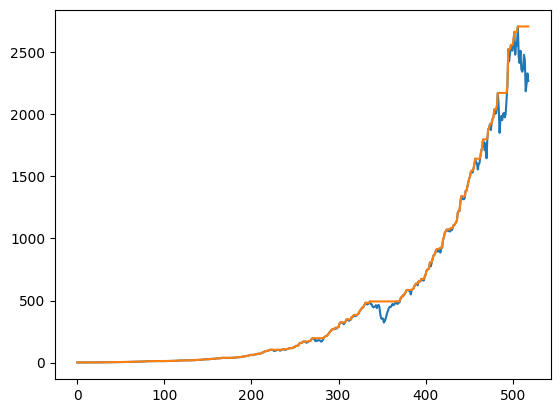

In [22]:
# 给net value画图
import matplotlib.pyplot as plt
plt.plot(gmv_net_value)
# plt.plot(enhanced_net_value)

In [18]:
# 导出merged_df
# merged_df.to_csv('R_3.csv', columns=['date','enhanced'], index=False)
